# Load Data

In [ ]:
import glob
import pandas as pd

In [ ]:
dataset_list = glob.glob("/content/drive/MyDrive/HateSpeech/Cleaned Dataset/*.csv")

In [ ]:
dataset_list

['/content/drive/MyDrive/HateSpeech/Cleaned Dataset/Benchmark.csv',
 '/content/drive/MyDrive/HateSpeech/Cleaned Dataset/Conan.csv',
 '/content/drive/MyDrive/HateSpeech/Cleaned Dataset/Dt.csv',
 '/content/drive/MyDrive/HateSpeech/Cleaned Dataset/Founta.csv',
 '/content/drive/MyDrive/HateSpeech/Cleaned Dataset/Wz_ls.csv',
 '/content/drive/MyDrive/HateSpeech/Cleaned Dataset/TCCC.csv',
 '/content/drive/MyDrive/HateSpeech/Cleaned Dataset/Multi.csv',
 '/content/drive/MyDrive/HateSpeech/Cleaned Dataset/THSD.csv',
 '/content/drive/MyDrive/HateSpeech/Cleaned Dataset/White.csv']

In [ ]:
datasets = []
for i in range(len(dataset_list)):
  datasets.append([pd.read_csv(dataset_list[i]).iloc[:,1:],dataset_list[i].split('.')[-2][50:]])

## preprocessing

In [ ]:
import re

def preprocess(text):
  # URL 제거
  text = re.sub('http\S+', '', text).strip()
  text = re.sub('^!!+', '', text).strip()
  text = re.sub('^(rt)', '', text).strip()
  # 멘션 제거
  text = re.sub('@\S+', '', text).strip()
  # 해쉬 및 특수문자 제거
  delete_e = re.compile("[^a-zA-Z0-9\!\?\$\%\' ]")
  text = delete_e.sub("",text).strip()
  text = text.lower()
  return text

print(preprocess(" !! rt ep rt gert bert http://sef.com !!"))

ep rt gert bert  !!


In [ ]:
for i in range(len(datasets)):
  print(f"{datasets[i][1]+ '(Before)':17s} : {datasets[i][0].duplicated().sum():5d}",end='\t')
  datasets[i][0] = datasets[i][0][~datasets[i][0].duplicated()]
  print(f"{datasets[i][1]+ '(After)':9s} : {datasets[i][0].duplicated().sum()}")

Benchmark(Before) :  3779	Benchmark(After) : 0
Conan(Before)     :     0	Conan(After) : 0
Dt(Before)        :     0	Dt(After) : 0
Founta(Before)    :  1483	Founta(After) : 0
Wz_ls(Before)     :  4027	Wz_ls(After) : 0
TCCC(Before)      :     0	TCCC(After) : 0
Multi(Before)     :     0	Multi(After) : 0
THSD(Before)      :  2434	THSD(After) : 0
White(Before)     :   169	White(After) : 0


In [ ]:
for i in range(len(datasets)):
  datasets[i][0]['text'] = datasets[i][0]['text'].apply(preprocess)
  print(f"{datasets[i][1]+ '(Before)':17s} : {datasets[i][0].duplicated().sum():5d}",end='\t')
  datasets[i][0] = datasets[i][0][~datasets[i][0].duplicated()]
  print(f"{datasets[i][1]+ '(After)':17s} : {datasets[i][0].duplicated().sum()}",end='\t')
  print(f"{datasets[i][1]:9s} : {len(datasets[i][0])}")

In [ ]:
datasets.append([pd.concat([datasets[1][0],datasets[6][0]]).reset_index(drop=True),'Conan+Multi'])

In [ ]:
for i in range(len(datasets)):
  print(i,datasets[i][1])

0 Benchmark
1 Conan
2 Dt
3 Founta
4 Wz_ls
5 TCCC
6 Multi
7 THSD
8 White
9 Conan+Multi


In [ ]:
datasets.pop(1)
datasets.pop(5)
print()

In [ ]:
for i in range(len(datasets)):
  print(f"{datasets[i][1]+ '(Before)':17s} : {datasets[i][0].duplicated().sum():5d}",end='\t')
  datasets[i][0] = datasets[i][0][~datasets[i][0].duplicated()]
  print(f"{datasets[i][1]+ '(After)':17s} : {datasets[i][0].duplicated().sum()}",end='\t')
  print(f"{datasets[i][1]:17s} : {len(datasets[i][0])}")

Benchmark(Before) :     0	Benchmark(After)  : 0	Benchmark         : 44284
Dt(Before)        :     0	Dt(After)         : 0	Dt                : 24783
Founta(Before)    :     0	Founta(After)     : 0	Founta            : 46748
Wz_ls(Before)     :     0	Wz_ls(After)      : 0	Wz_ls             : 13125
TCCC(Before)      :     0	TCCC(After)       : 0	TCCC              : 159571
THSD(Before)      :     0	THSD(After)       : 0	THSD              : 29528
White(Before)     :     0	White(After)      : 0	White             : 10534
Conan+Multi(Before) :    35	Conan+Multi(After) : 0	Conan+Multi       : 7923


## GloVe

In [ ]:
import numpy as np
embeddings_index = {}
f = open("/content/drive/MyDrive/HateSpeech/glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


# ORINGIN DATASETS

## Build model

In [ ]:
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import *

def build_model(num_words,embedding_matrix):
  model = Sequential()
  model.add(Embedding(num_words,
                      embedding_dim,
                      embeddings_initializer=Constant(embedding_matrix),
                      input_length=sequence_length,
                      trainable=True))
  model.add(SpatialDropout1D(0.2))
  model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))
  model.add(Bidirectional(CuDNNLSTM(32)))
  model.add(Dropout(0.25))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
  return model

## Train

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings(action='ignore')

eval = pd.DataFrame([[np.nan for i in range(10)]])
eval.columns = ['Model','Train_Dataset','Test_Dataset','Train_Score(ACC)','Train_Score(ROC_AUC)','Train_Score(F1)','Test_Score(ACC)','Test_Score(ROC_AUC)','Test_Score(F1)','Inference_Time']
eval = eval.iloc[1:]

max_features=100000
sequence_length = 235
embedding_dim = 100
num_words = 100001

for train_d in datasets:
  tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>', filters=' ')
  tokenizer.fit_on_texts(train_d[0]['text'])
  X_train = tokenizer.texts_to_sequences(train_d[0]['text'])
  X_train = pad_sequences(X_train, sequence_length)
  y_train = train_d[0]['class']

  X_train = shuffle(X_train,random_state=42)
  y_train = shuffle(y_train.values,random_state=42)

  word_index = tokenizer.word_index
  embedding_matrix_train = np.zeros((num_words, embedding_dim))

  for word, i in word_index.items():
      if i > max_features:
          continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # we found the word - add that words vector to the matrix
          embedding_matrix_train[i] = embedding_vector
      else:
          # doesn't exist, assign a random vector
          embedding_matrix_train[i] = np.random.randn(embedding_dim)

  print(train_d[1],'-'*100)
  LR = build_model(num_words,embedding_matrix_train)
  LR.fit(X_train,y_train,epochs=10,batch_size=256)
  fitted = LR.predict_classes(X_train)
  fitted_proba = LR.predict_proba(X_train)
  train_acc = accuracy_score(y_train,fitted)
  train_auc = roc_auc_score(y_train,fitted_proba)
  train_f1 = f1_score(y_train,fitted)

  LR_list_base = ['BiLSTM+GloVe(10)']
  LR_list_base.append(train_d[1])

  for test_d in datasets:
    X_test = tokenizer.texts_to_sequences(test_d[0]['text'])
    X_test = pad_sequences(X_test, sequence_length)
    y_test = test_d[0]['class']
    y_test = y_test.values
    X_test = shuffle(X_test,random_state=42)
    y_test = shuffle(y_test,random_state=42)
    word_index = tokenizer.word_index
    embedding_matrix_test = np.zeros((num_words, embedding_dim))

    start = time.time()
    pred = LR.predict_classes(X_test)
    inference_time = time.time()-start
    pred_proba = LR.predict_proba(X_test)
    print(f"{test_d[1]} Inferenced : {inference_time}s",end='\t')

    # Evaluate
    test_acc = accuracy_score(y_test,pred)
    test_auc = roc_auc_score(y_test,pred_proba)
    test_f1 = f1_score(y_test,pred)
    print(f"train ACC : {train_acc} train F1 : {train_f1} test ACC : {test_acc} test ROCAUC : {test_auc} test F1 : {test_f1}")

    LR_list = LR_list_base.copy()
    LR_list.append(test_d[1])
    LR_list.append(train_acc)
    LR_list.append(train_auc)
    LR_list.append(train_f1)
    LR_list.append(test_acc)
    LR_list.append(test_auc)
    LR_list.append(test_f1)
    LR_list.append(inference_time)

    eval = eval.append(pd.DataFrame([LR_list],columns=eval.columns))

Benchmark ----------------------------------------------------------------------------------------------------
Epoch 1/10
171/171 [==============================] - 21s 109ms/step - loss: 0.5650 - accuracy: 0.7046
Epoch 2/10
171/171 [==============================] - 19s 108ms/step - loss: 0.2897 - accuracy: 0.8982
Epoch 3/10
171/171 [==============================] - 19s 109ms/step - loss: 0.2431 - accuracy: 0.9177
Epoch 4/10
171/171 [==============================] - 19s 108ms/step - loss: 0.2218 - accuracy: 0.9242
Epoch 5/10
171/171 [==============================] - 18s 108ms/step - loss: 0.2081 - accuracy: 0.9290
Epoch 6/10
171/171 [==============================] - 19s 108ms/step - loss: 0.1951 - accuracy: 0.9309
Epoch 7/10
171/171 [==============================] - 19s 108ms/step - loss: 0.1731 - accuracy: 0.9387
Epoch 8/10
171/171 [==============================] - 19s 109ms/step - loss: 0.1590 - accuracy: 0.9436
Epoch 9/10
171/171 [==============================] - 18s 108ms/s

In [ ]:
eval.to_csv("/content/drive/MyDrive/HateSpeech/PERFORMANCE/dataset_validation_GloVeBiLSTM20.csv")

## Table

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/HateSpeech/PERFORMANCE/dataset_validation_GloVeBiLSTM20.csv").iloc[:,1:]

datasets_len = {datasets[i][1]:len(datasets[i][0]) for i in range(len(datasets))}
df['length']=df['Train_Dataset'].apply(lambda x : datasets_len[x])

# df['val_factor'] = df['Test_Score(ACC)']*df['Test_Score(F1)']*df['length'].apply(lambda x : 1/x)*100000
df['val_factor'] =( df['Test_Score(ROC_AUC)']/(df['length']**0.1))
# df = df[['Train_Dataset','Test_Dataset','val_factor']]
# df_per = pd.crosstab(df['Train_Dataset'],df['Test_Dataset'],df['val_factor'],aggfunc=sum)
df_per = pd.crosstab(df['Train_Dataset'],df['Test_Dataset'],df['val_factor'],aggfunc=sum)
for col_0 in df_per:
  for col_1 in df_per:
    if col_0==col_1:
      df_per[col_0][col_1]=0
df_per

Test_Dataset,Benchmark,Conan+Multi,Dt,Founta,TCCC,THSD,White,Wz_ls
Train_Dataset,,,,,,,,
Benchmark,0.000000,0.213137,0.282469,0.252480,0.267275,0.199108,0.254625,0.179571
Conan+Multi,0.204096,0.000000,0.207932,0.221379,0.250139,0.183333,0.184025,0.186930
Dt,0.304597,0.191471,0.000000,0.305447,0.313182,0.207535,0.213047,0.228598
Founta,0.272610,0.221099,0.310295,0.000000,0.298827,0.237034,0.230566,0.222104
TCCC,0.255618,0.188278,0.272932,0.267750,0.000000,0.179697,0.213813,0.198580
THSD,0.201793,0.193390,0.205399,0.241734,0.229279,0.000000,0.213932,0.237636
White,0.233928,0.261433,0.245944,0.262461,0.279883,0.238411,0.000000,0.205383
Wz_ls,0.246260,0.197594,0.293425,0.235119,0.240068,0.264598,0.238564,0.000000


In [ ]:
df_per.to_csv('Single_Train_Val_Score.csv')

In [ ]:
df_per['mean']=(df_per['Benchmark']+df_per['Conan+Multi']+df_per['Dt']+df_per['Founta']+df_per['TCCC']+df_per['THSD']+df_per['White']+df_per['Wz_ls'])/7

## Heatmap

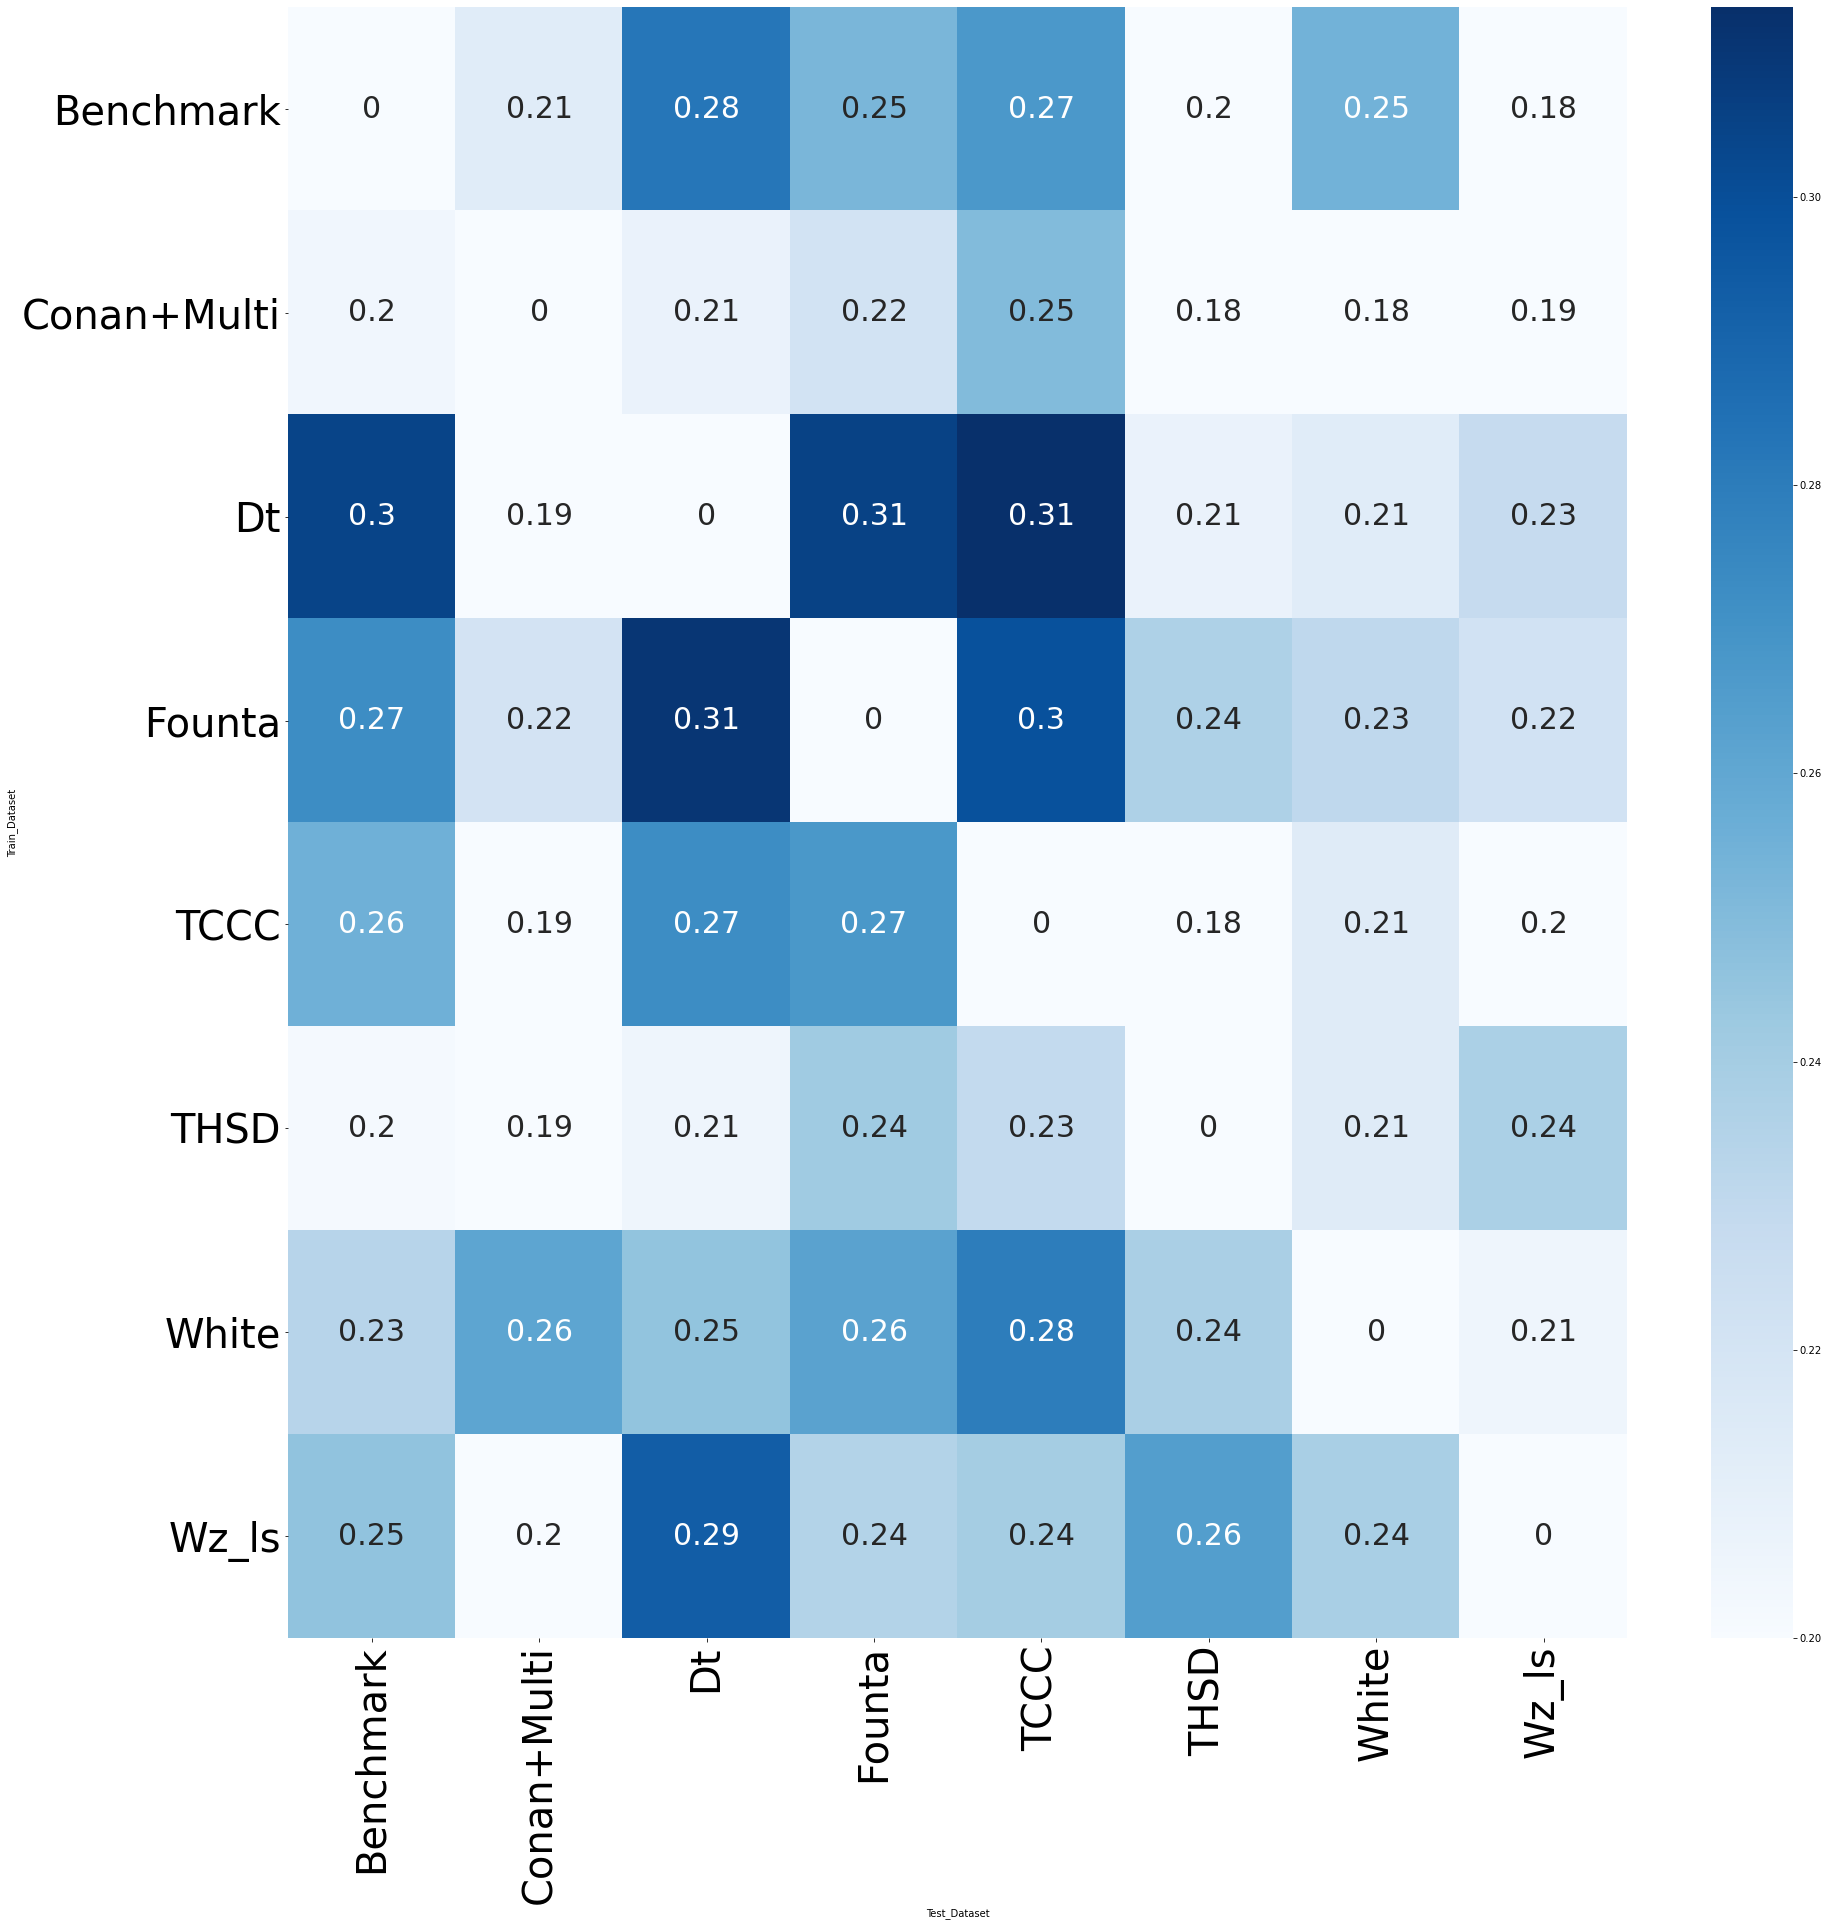

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(df_per,annot=True,cmap='Blues',vmin=0.2,annot_kws={'fontsize':30})

# Combination

## Load HateEVAL, OLID

In [ ]:
HateEval = pd.read_csv('https://raw.githubusercontent.com/cicl2018/HateEvalTeam/master/Data%20Files/Data%20Files/%232%20Development-English-A/train_dev_en_merged.tsv',sep='\t').iloc[:,1:]
HateEval['class']=HateEval['HS']
HateEval = HateEval[['text','class']]
dup1 = HateEval.duplicated()
HateEval = HateEval[~dup1].reset_index(drop=True)
HateEval['text'] = HateEval['text'].apply(preprocess)
dup2 = HateEval.duplicated()
HateEval = HateEval[~dup2].reset_index(drop=True)
print(dup1.sum(),dup2.sum())
OLID = pd.read_csv("/content/sample_data/olid-training-v1.0.tsv",sep='\t').iloc[:,1:3]
OLID['class'] = OLID['subtask_a'].replace({"OFF":1,"NOT":0})
OLID['text'] = OLID['tweet']
OLID = OLID[['text','class']]
dup1 = OLID.duplicated()
OLID = OLID[~dup1].reset_index(drop=True)
OLID['text'] = OLID['text'].apply(preprocess)
dup2 = OLID.duplicated()
OLID = OLID[~dup2].reset_index(drop=True)
print(dup1.sum(),dup2.sum())
HO = pd.concat([HateEval,OLID])
dup1 = HO.duplicated()
HO = HO[~dup1].reset_index(drop=True)
HO['text'] = HO['text'].apply(preprocess)
dup2 = HO.duplicated()
HO = HO[~dup2].reset_index(drop=True)
print(dup1.sum(),dup2.sum())

datasets.append([HateEval,'HateEval'])
datasets.append([OLID,'OLID'])
HO

2 33
28 91
3 3


,text,class
0,hurray saving us $$$ in so many ways lockthe...,1
1,why would young fighting age men be the vast m...,1
2,illegals dump their kids at the border like ro...,1
3,ny times 'nearly all white' states pose 'an ar...,0
4,orban in brussels european leaders are ignorin...,0
...,...,...
23075,sometimes i get strong vibes from people and t...,1
23076,benidorm creamfields maga not too shabb...,0
23077,and why report this garbage we don't give a crap,1
23078,pussy,1


In [ ]:
for i in range(len(datasets)):
  print(i,datasets[i][1])

0 Benchmark
1 Dt
2 Founta
3 Wz_ls
4 TCCC
5 THSD
6 White
7 Conan+Multi
8 HateEval
9 OLID


In [ ]:
import random
collection_list = []
col_list = [0,1,2,6,3,8,9]
collection_list.append([0,1,2,6,3])
collection_list.append([8,9])
k=0
while True:
  dataset_num = random.randint(2,len(col_list))
  temp=[]
  i=0
  while True:
    collection = col_list[random.randint(0,len(col_list)-1)]
    if collection in temp: continue
    temp.append(collection)
    i+=1
    if i == dataset_num: break
  temp = sorted(temp)
  if temp in collection_list :
    continue
  collection_list.append(temp)
  k+=1
  if k==8: break 
k=0
while True:
  dataset_num = random.randint(2,9)
  temp=[]
  i=0
  while True:
    collection = random.randint(0,9)
    if collection in temp: continue
    temp.append(collection)
    i+=1
    if i == dataset_num: break
  temp = sorted(temp)
  if temp in collection_list :
    continue
  collection_list.append(temp)
  k+=1
  if k==42: break 

In [ ]:
datasets_copy = []
No=1
print('No.\tdup1\tdup2\tlen\tname')
for dummy in collection_list:
  temp = datasets[dummy[0]][0]
  temp_name = datasets[dummy[0]][1]
  for i in dummy[1:]:
    to_concat = datasets[i][0]
    temp = pd.concat([temp,to_concat])
    temp_name = temp_name + "+" +datasets[i][1]
  dup1 = temp.duplicated()
  temp = temp[~dup1].reset_index(drop=True)
  temp['text'] = temp['text'].apply(preprocess)
  dup2 = temp.duplicated()
  temp = temp[~dup2].reset_index(drop=True)
  print(No,end='\t')
  print(dup1.sum(),end='\t')
  print(dup2.sum(),end='\t')
  print(len(temp),end='\t')
  print(temp_name)
  No+=1
  datasets_copy.append([temp,temp_name])

No.	dup1	dup2	len	name
1	123	809	134138	Benchmark+Dt+Founta+White+Wz_ls
2	3	3	23080	HateEval+OLID
3	30	196	66979	Founta+White+OLID
4	20	587	80379	Benchmark+Dt+Wz_ls
5	136	816	144083	Benchmark+Dt+Founta+Wz_ls+White+HateEval
6	167	830	157159	Benchmark+Dt+Founta+Wz_ls+White+HateEval+OLID
7	34	667	103240	Dt+Founta+Wz_ls+HateEval+OLID
8	110	789	146780	Benchmark+Dt+Founta+Wz_ls+HateEval+OLID
9	157	676	132819	Benchmark+Founta+Wz_ls+White+HateEval+OLID
10	115	274	110554	Benchmark+Founta+White+OLID
11	10	1281	114172	Dt+Founta+THSD+Conan+Multi+HateEval
12	0	1439	65279	Dt+Wz_ls+THSD
13	92	266	105381	Benchmark+Founta+White+Conan+Multi
14	72	431	245362	Benchmark+Dt+TCCC+White+Conan+Multi
15	175	1029	314133	Benchmark+Dt+Founta+Wz_ls+TCCC+White+Conan+Multi+OLID
16	87	293	226185	Benchmark+TCCC+White+OLID
17	0	201	166945	TCCC+Conan+Multi
18	176	1831	193536	Benchmark+Dt+Founta+Wz_ls+THSD+White+Conan+Multi+HateEval+OLID
19	7	202	180058	TCCC+Conan+Multi+OLID
20	154	1822	175685	Benchmark+Dt+Founta+Wz_ls+TH

In [ ]:
df_dataset = pd.DataFrame([[np.nan for i in range(5)]])
df_dataset.columns = ['No','OBJ','Dataset','length','collection_list']
df_dataset = df_dataset.iloc[1:]

No=1
for k in datasets_copy:
  df_dataset = df_dataset.append(pd.DataFrame([[No,'Train',k[1],len(k[0]),collection_list[No-1]]],columns=df_dataset.columns))
  No+=1
No=1
for k in datasets:
  df_dataset = df_dataset.append(pd.DataFrame([[No,'Test',k[1],len(k[0]),'']],columns=df_dataset.columns))
  No+=1
df_dataset.to_csv("/content/drive/MyDrive/HateSpeech/PERFORMANCE/combination_dataset_validation_list.csv")
df_dataset

,No,OBJ,Dataset,length,collection_list
0,1.0,Train,Benchmark+Dt+Founta+White+Wz_ls,134138.0,"[0, 1, 2, 6, 3]"
0,2.0,Train,HateEval+OLID,23080.0,"[8, 9]"
0,3.0,Train,Founta+White+OLID,66979.0,"[2, 6, 9]"
0,4.0,Train,Benchmark+Dt+Wz_ls,80379.0,"[0, 1, 3]"
0,5.0,Train,Benchmark+Dt+Founta+Wz_ls+White+HateEval,144083.0,"[0, 1, 2, 3, 6, 8]"
...,...,...,...,...,...
0,6.0,Test,THSD,29470.0,
0,7.0,Test,White,10477.0,
0,8.0,Test,Conan+Multi,7917.0,
0,9.0,Test,HateEval,9965.0,


In [ ]:
df_dataset = pd.read_csv("/content/drive/MyDrive/HateSpeech/PERFORMANCE/combination_dataset_validation_list.csv").iloc[:,1:]
df_dataset

,No,OBJ,Dataset,length,collection_list
0,1.0,Train,Benchmark+Dt+Founta+White+Wz_ls,134138.0,"[0, 1, 2, 6, 3]"
1,2.0,Train,HateEval+OLID,23080.0,"[8, 9]"
2,3.0,Train,Founta+White+OLID,66979.0,"[2, 6, 9]"
3,4.0,Train,Benchmark+Dt+Wz_ls,80379.0,"[0, 1, 3]"
4,5.0,Train,Benchmark+Dt+Founta+Wz_ls+White+HateEval,144083.0,"[0, 1, 2, 3, 6, 8]"
...,...,...,...,...,...
57,6.0,Test,THSD,29470.0,NaN
58,7.0,Test,White,10477.0,NaN
59,8.0,Test,Conan+Multi,7917.0,NaN
60,9.0,Test,HateEval,9965.0,NaN


## Train

In [ ]:
eval

,Model,Train_Dataset,Test_Dataset,Train_Score(ACC),Train_Score(ROC_AUC),Train_Score(F1),Test_Score(ACC),Test_Score(ROC_AUC),Test_Score(F1),Inference_Time
0,BiLSTM+GloVe(10),Benchmark+Dt+Founta+White+Wz_ls,Benchmark,0.973900,0.996701,0.964507,0.972907,0.996728,0.968782,22.232107
0,BiLSTM+GloVe(10),Benchmark+Dt+Founta+White+Wz_ls,Dt,0.973900,0.996701,0.964507,0.989145,0.998712,0.993478,12.452341
0,BiLSTM+GloVe(10),Benchmark+Dt+Founta+White+Wz_ls,Founta,0.973900,0.996701,0.964507,0.981563,0.996618,0.931574,22.087154
0,BiLSTM+GloVe(10),Benchmark+Dt+Founta+White+Wz_ls,Wz_ls,0.973900,0.996701,0.964507,0.924592,0.976763,0.850938,6.449153
0,BiLSTM+GloVe(10),Benchmark+Dt+Founta+White+Wz_ls,TCCC,0.973900,0.996701,0.964507,0.910632,0.845740,0.452734,80.979441
...,...,...,...,...,...,...,...,...,...,...
0,BiLSTM+GloVe(10),Benchmark+TCCC+White+OLID,THSD,0.982475,0.997829,0.950310,0.878453,0.626084,0.163866,15.017981
0,BiLSTM+GloVe(10),Benchmark+TCCC+White+OLID,White,0.982475,0.997829,0.950310,0.969075,0.989663,0.856890,5.355957
0,BiLSTM+GloVe(10),Benchmark+TCCC+White+OLID,Conan+Multi,0.982475,0.997829,0.950310,0.860553,0.663080,0.194161,4.065361
0,BiLSTM+GloVe(10),Benchmark+TCCC+White+OLID,HateEval,0.982475,0.997829,0.950310,0.642449,0.686369,0.490053,5.084342


In [ ]:
temp=[]
for i in range(len(datasets)):
  X = shuffle(datasets[i][0],random_state=42)
  X_train = X.iloc[:int(len(datasets[i][0])*0.8)]
  X_val = X.iloc[int(len(datasets[i][0])*0.8):]
  temp.append([datasets[i][0],datasets[i][1],X_train,X_val])
datasets = temp

In [ ]:
datasets_copy=[]
for dummy in [[0,1,2,3,4,6,8,9]]:
  temp = datasets[dummy[0]][0]
  temp_name = datasets[dummy[0]][1]
  for i in dummy[1:]:
    to_concat = datasets[i][0]
    temp = pd.concat([temp,to_concat])
    temp_name = temp_name + "+" +datasets[i][1]
  dup1 = temp.duplicated()
  temp = temp[~dup1].reset_index(drop=True)
  temp['text'] = temp['text'].apply(preprocess)
  dup2 = temp.duplicated()
  temp = temp[~dup2].reset_index(drop=True)
  # print(No,end='\t')
  print(dup1.sum(),end='\t')
  print(dup2.sum(),end='\t')
  print(len(temp),end='\t')
  print(temp_name)
  # No+=1
  datasets_copy.append([temp,temp_name])

305	343	316167	Benchmark+Dt+Founta+Wz_ls+TCCC+White+HateEval+OLID


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings(action='ignore')

eval = pd.DataFrame([[np.nan for i in range(10)]])
eval.columns = ['Model','Train_Dataset','Test_Dataset','Train_Score(ACC)','Train_Score(ROC_AUC)','Train_Score(F1)','Test_Score(ACC)','Test_Score(ROC_AUC)','Test_Score(F1)','Inference_Time']
eval = eval.iloc[1:]

max_features=100000
sequence_length = 235
embedding_dim = 100
num_words = 100001
COUNT_ITER = 1000

for train_d in datasets_copy:
  # if COUNT_ITER<=42 :
  #   print(COUNT_ITER,train_d[1],"already done!")
  #   COUNT_ITER+=1
  #   continue
  data_start = time.time()
  tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>', filters=' ')
  tokenizer.fit_on_texts(train_d[0]['text'])
  X_train = tokenizer.texts_to_sequences(train_d[0]['text'])
  X_train = pad_sequences(X_train, sequence_length)
  y_train = train_d[0]['class']

  X_train = shuffle(X_train,random_state=42)
  y_train = shuffle(y_train.values,random_state=42)

  word_index = tokenizer.word_index
  embedding_matrix_train = np.zeros((num_words, embedding_dim))

  for word, i in word_index.items():
      if i > max_features:
          continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # we found the word - add that words vector to the matrix
          embedding_matrix_train[i] = embedding_vector
      else:
          # doesn't exist, assign a random vector
          embedding_matrix_train[i] = np.random.randn(embedding_dim)

  print(COUNT_ITER,train_d[1],'-'*100)
  LR = build_model(num_words,embedding_matrix_train)
  LR.fit(X_train,y_train,epochs=3,batch_size=256)
  fitted = LR.predict_classes(X_train)
  fitted_proba = LR.predict_proba(X_train)
  train_acc = accuracy_score(y_train,fitted)
  train_auc = roc_auc_score(y_train,fitted_proba)
  train_f1 = f1_score(y_train,fitted)

  LR_list_base = ['BiLSTM+GloVe(10)']
  LR_list_base.append(train_d[1])

  for test_d in datasets:
    X_test = tokenizer.texts_to_sequences(test_d[3]['text'])
    X_test = pad_sequences(X_test, sequence_length)
    y_test = test_d[3]['class']
    y_test = y_test.values
    X_test = shuffle(X_test,random_state=42)
    y_test = shuffle(y_test,random_state=42)
    word_index = tokenizer.word_index
    embedding_matrix_test = np.zeros((num_words, embedding_dim))

    start = time.time()
    pred = LR.predict_classes(X_test)
    inference_time = time.time()-start
    pred_proba = LR.predict_proba(X_test)
    print(f"{test_d[1]} Inferenced : {inference_time}s",end='\t')

    # Evaluate
    test_acc = accuracy_score(y_test,pred)
    test_auc = roc_auc_score(y_test,pred_proba)
    test_f1 = f1_score(y_test,pred)
    print(f"train ACC : {train_acc} train F1 : {train_f1} test ACC : {test_acc} test ROCAUC : {test_auc} test F1 : {test_f1}")

    LR_list = LR_list_base.copy()
    LR_list.append(test_d[1])
    LR_list.append(train_acc)
    LR_list.append(train_auc)
    LR_list.append(train_f1)
    LR_list.append(test_acc)
    LR_list.append(test_auc)
    LR_list.append(test_f1)
    LR_list.append(inference_time)

    eval = eval.append(pd.DataFrame([LR_list],columns=eval.columns))
  eval.to_csv(f"/content/drive/MyDrive/HateSpeech/PERFORMANCE/combination_{COUNT_ITER:02d}_dataset_validation_GloVeBiLSTM20.csv")
  COUNT_ITER += 1
  print(f"SAVED!!! {time.time()-data_start}")

1000 Benchmark+Dt+Founta+Wz_ls+TCCC+White+HateEval+OLID ----------------------------------------------------------------------------------------------------
Epoch 1/3
1236/1236 [==============================] - 140s 110ms/step - loss: 0.3266 - accuracy: 0.8662
Epoch 2/3
1236/1236 [==============================] - 136s 110ms/step - loss: 0.2144 - accuracy: 0.9156
Epoch 3/3
1236/1236 [==============================] - 136s 110ms/step - loss: 0.1913 - accuracy: 0.9244
Benchmark Inferenced : 4.4856438636779785s	train ACC : 0.931884099226042 train F1 : 0.8432947682456523 test ACC : 0.9079775666704819 test ROCAUC : 0.9668408526567975 test F1 : 0.8920225624496374
Dt Inferenced : 2.629380702972412s	train ACC : 0.931884099226042 train F1 : 0.8432947682456523 test ACC : 0.95069558101473 test ROCAUC : 0.9829396913398761 test F1 : 0.9702064532080604
Founta Inferenced : 4.5531110763549805s	train ACC : 0.931884099226042 train F1 : 0.8432947682456523 test ACC : 0.9384562291498907 test ROCAUC : 0.95

In [ ]:
i=0
for test_d in datasets:
  i+=1
  if i <4: continue
  X_test = tokenizer.texts_to_sequences(test_d[0]['text'])
  X_test = pad_sequences(X_test, sequence_length)
  y_test = test_d[0]['class']
  y_test = y_test.values
  X_test = shuffle(X_test,random_state=42)
  y_test = shuffle(y_test,random_state=42)
  word_index = tokenizer.word_index
  embedding_matrix_test = np.zeros((num_words, embedding_dim))

  start = time.time()
  pred = LR.predict_classes(X_test)
  inference_time = time.time()-start
  pred_proba = LR.predict_proba(X_test)
  print(f"{test_d[1]} Inferenced : {inference_time}s",end='\t')

  # Evaluate
  test_acc = accuracy_score(y_test,pred)
  test_auc = roc_auc_score(y_test,pred_proba)
  test_f1 = f1_score(y_test,pred)
  print(f"train ACC : {train_acc} train F1 : {train_f1} test ACC : {test_acc} test ROCAUC : {test_auc} test F1 : {test_f1}")

  LR_list = LR_list_base.copy()
  LR_list.append(test_d[1])
  LR_list.append(train_acc)
  LR_list.append(train_auc)
  LR_list.append(train_f1)
  LR_list.append(test_acc)
  LR_list.append(test_auc)
  LR_list.append(test_f1)
  LR_list.append(inference_time)

  eval = eval.append(pd.DataFrame([LR_list],columns=eval.columns))

Wz_ls Inferenced : 6.490233421325684s	train ACC : 0.9329373400766051 train F1 : 0.8516287043840314 test ACC : 0.8338206242591861 test ROCAUC : 0.88788084868922 test F1 : 0.6486215538847119


KeyboardInterrupt: ignored

In [ ]:

eval = pd.DataFrame([[np.nan for i in range(10)]])
eval.columns = ['Model','Train_Dataset','Test_Dataset','Train_Score(ACC)','Train_Score(ROC_AUC)','Train_Score(F1)','Test_Score(ACC)','Test_Score(ROC_AUC)','Test_Score(F1)','Inference_Time']
eval = eval.iloc[1:]
eval = eval.append(pd.DataFrame([LR_list],columns=eval.columns))
eval

,Model,Train_Dataset,Test_Dataset,Train_Score(ACC),Train_Score(ROC_AUC),Train_Score(F1),Test_Score(ACC),Test_Score(ROC_AUC),Test_Score(F1),Inference_Time
0,BiLSTM+GloVe(10),Benchmark+Dt+Founta+Wz_ls+TCCC+White+HateEval+...,Benchmark,0.932937,0.976871,0.851629,0.891875,0.967592,0.880379,22.214679


## Table

In [ ]:
num_of_data = df_dataset[['Dataset','length']].set_index('Dataset',drop=True).to_dict()['length']

NameError: ignored

In [ ]:
eval

,Model,Train_Dataset,Test_Dataset,Train_Score(ACC),Train_Score(ROC_AUC),Train_Score(F1),Test_Score(ACC),Test_Score(ROC_AUC),Test_Score(F1),Inference_Time
0,BiLSTM+GloVe(10),Benchmark+Dt+Founta+Wz_ls+TCCC+White+HateEval+...,Benchmark,0.931884,0.977343,0.843295,0.907978,0.966841,0.892023,4.485644
0,BiLSTM+GloVe(10),Benchmark+Dt+Founta+Wz_ls+TCCC+White+HateEval+...,Dt,0.931884,0.977343,0.843295,0.950696,0.982940,0.970206,2.629381
0,BiLSTM+GloVe(10),Benchmark+Dt+Founta+Wz_ls+TCCC+White+HateEval+...,Founta,0.931884,0.977343,0.843295,0.938456,0.956623,0.741171,4.553111
0,BiLSTM+GloVe(10),Benchmark+Dt+Founta+Wz_ls+TCCC+White+HateEval+...,Wz_ls,0.931884,0.977343,0.843295,0.839194,0.893347,0.641410,1.352094
0,BiLSTM+GloVe(10),Benchmark+Dt+Founta+Wz_ls+TCCC+White+HateEval+...,TCCC,0.931884,0.977343,0.843295,0.965510,0.988181,0.801232,16.307426
0,BiLSTM+GloVe(10),Benchmark+Dt+Founta+Wz_ls+TCCC+White+HateEval+...,THSD,0.931884,0.977343,0.843295,0.910016,0.741092,0.163132,2.976819
0,BiLSTM+GloVe(10),Benchmark+Dt+Founta+Wz_ls+TCCC+White+HateEval+...,White,0.931884,0.977343,0.843295,0.907788,0.920984,0.391167,1.164161
0,BiLSTM+GloVe(10),Benchmark+Dt+Founta+Wz_ls+TCCC+White+HateEval+...,Conan+Multi,0.931884,0.977343,0.843295,0.898990,0.694476,0.111111,0.916963
0,BiLSTM+GloVe(10),Benchmark+Dt+Founta+Wz_ls+TCCC+White+HateEval+...,HateEval,0.931884,0.977343,0.843295,0.765178,0.867865,0.710754,1.055424
0,BiLSTM+GloVe(10),Benchmark+Dt+Founta+Wz_ls+TCCC+White+HateEval+...,OLID,0.931884,0.977343,0.843295,0.775238,0.885679,0.516393,1.360707


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/HateSpeech/PERFORMANCE/combination_43_dataset_validation_GloVeBiLSTM20.csv").iloc[:,1:]
df = pd.concat([eval,df])
df['number_of_datasets'] = df['Train_Dataset'].apply(lambda x : len(x.split('+')))
df['Train_Dataset'] = df['Train_Dataset'] + " [" + df['number_of_datasets'].apply(lambda x : str(x)) +']'
df_per = pd.crosstab(df['Train_Dataset'],df['Test_Dataset'],df['Test_Score(ROC_AUC)'],aggfunc=sum)
# df_per['number_of_data'] = df_per['Train_Dataset'].apply(lambda x : num_of_data[x])
df_per['mean'] = (df_per['Benchmark']+df_per['Dt']+df_per['Founta']+df_per['HateEval']+df_per['OLID']+df_per['TCCC']+df_per['THSD']+df_per['White']+df_per['Wz_ls'])/9
# df_per['val_factor'] = df_per['mean']/((df_per['number_of_data'])**0.1)*3
# df_per = df_per.sort_values('val_factor',ascending=False).set_index('Train_Dataset',drop=True)
df_per = df_per.sort_values('mean',ascending=False)
df_per

TypeError: ignored

In [ ]:
df_per.to_csv("Combination_Train_Val_SCORES.csv")

## Heatmap

In [ ]:
df_per = pd.read_csv("Combination_Train_Val_SCORES.csv").set_index('Train_Dataset')
df_per2 = pd.DataFrame(pd.concat([df_per[:5],df_per[-5:]]))

In [ ]:
df_per2.to_csv("fff.csv")

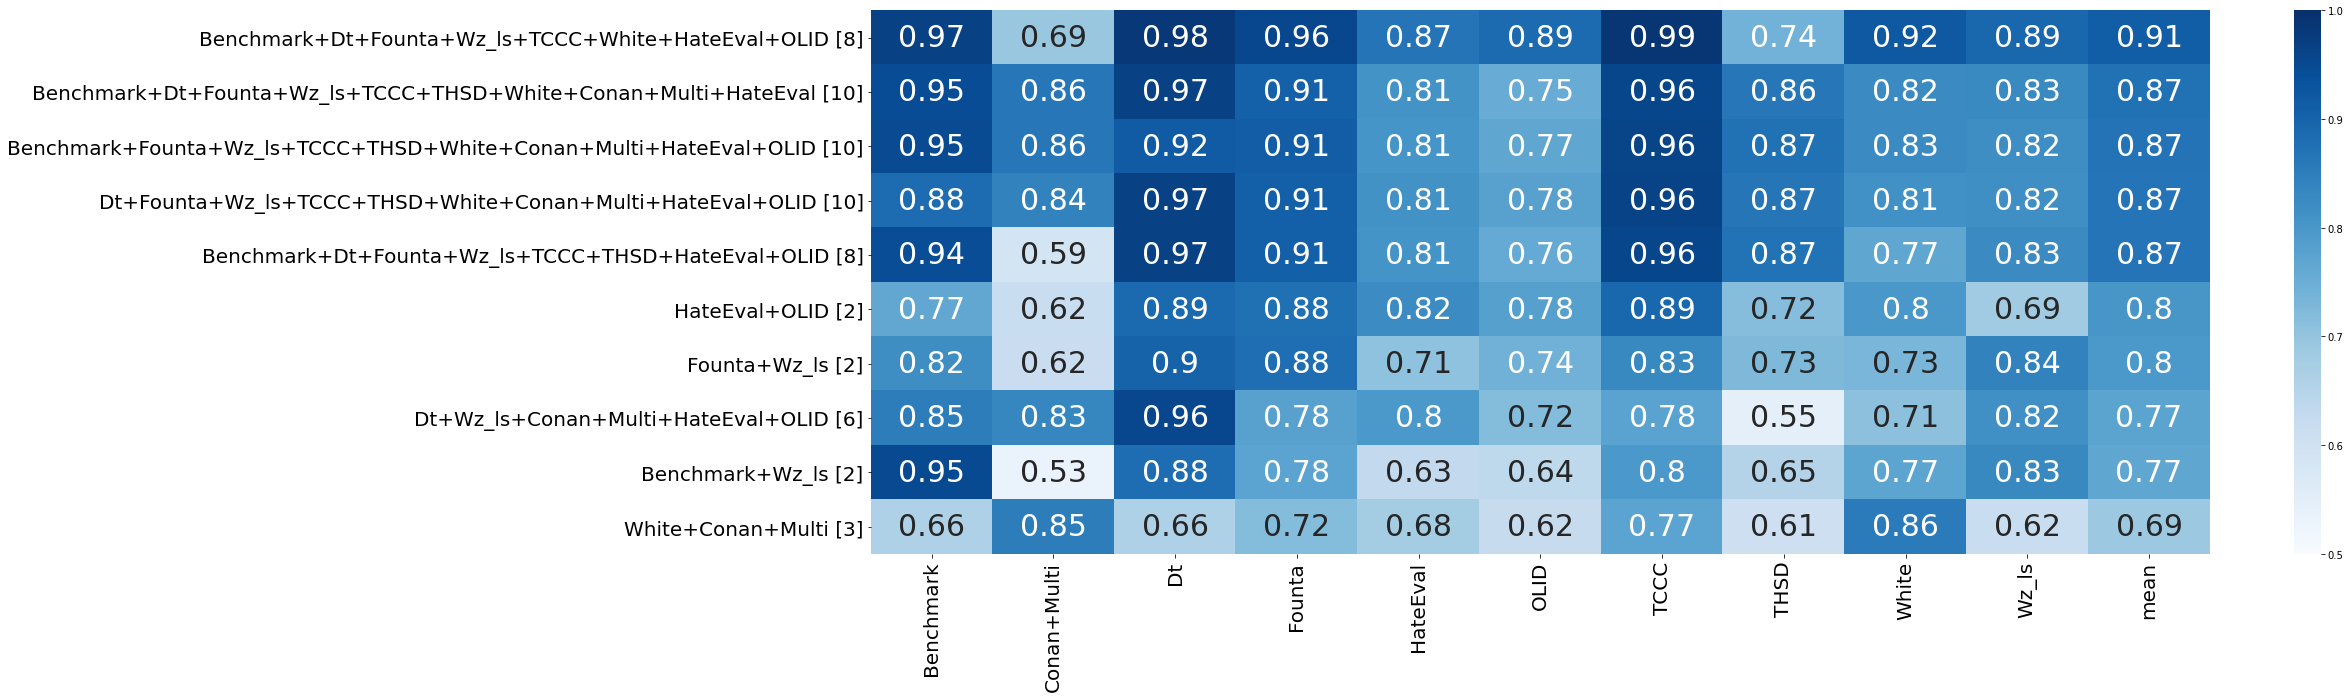

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.heatmap(pd.concat([df_per[:5],df_per[-5:]]),annot=True,cmap='Blues',vmax=1,vmin=0.5,annot_kws={'fontsize':30})
plt.xlabel(None)
plt.ylabel(None)
plt.show()

In [ ]:
len(df_per)

44

# Final Dataset

## Concat

In [ ]:
temp = datasets[0][0]
for tt in datasets[1:]:
  if tt[1] in ['THSD','Conan+Multi']:
    print(tt[1],'out')
  temp = pd.concat([temp,tt[0]])
temp

THSD out
Conan+Multi out


,text,class
0,this is what the left is really scared of,0
1,that literally looks like a monkey why are we ...,0
2,it makes you an asshole,0
3,so they manage to provide a whole lot of data ...,0
4,hi there im keith i hope you are doing well i ...,0
...,...,...
13116,sometimes i get strong vibes from people and t...,1
13117,benidorm creamfields maga not too shabb...,0
13118,and why report this garbage we don't give a crap,1
13119,pussy,1


## Imbalance dataset

In [ ]:
temp = temp.reset_index(drop=True)
dup1 = temp.duplicated()
temp = temp[~dup1].reset_index(drop=True)
temp['text'] = temp['text'].apply(preprocess)
dup2 = temptemp
temp = temp[~dup2].reset_index(drop=True)
print(dup1.sum(),dup2.sum())

350 343


In [ ]:
from sklearn.utils import shuffle
final_dataset =  shuffle(shuffle(shuffle(temp))).reset_index(drop=True)
final_dataset

,text,class
0,justice for bud cruel students lit up fire cra...,0
1,perry ross schiro 19 of harnett county was c...,0
2,go back and read your own posts your look at m...,1
3,watching your return in welcomehome,0
4,until you successfully appeal your ban you'll ...,0
...,...,...
352538,the truth lives on when you decrease the suppl...,0
352539,retail strategy today a blended online and ins...,0
352540,i've been working in computers since 1980 at t...,0
352541,there is already a process for this at wpcfds ...,0


In [ ]:
final_dataset.to_csv("/content/drive/MyDrive/HateSpeech/FINAL_DATASET/Final_dataset_imbalanced.csv")

In [ ]:
final_dataset['class'].value_counts()

0    275402
1     77141
Name: class, dtype: int64

## Balance dataset

In [ ]:
fianl_dataset_balanced = shuffle(shuffle(pd.concat([final_dataset[final_dataset['class']==0].sample(77141),final_dataset[final_dataset['class']==1]]))).reset_index(drop=True)

In [ ]:
print(fianl_dataset_balanced['class'].value_counts())
fianl_dataset_balanced

1    77141
0    77141
Name: class, dtype: int64


,text,class
0,pulling for you on the 8th! you got this go ge...,0
1,atheists only exist if god does that's the mos...,1
2,the afd on outer yes there is quite a listwith...,0
3,a dick has a sad life his hair is a mess his f...,1
4,i'll respond with nigger jew bitch sandpeople ...,1
...,...,...
154277,grandma terri die in trash! i fcking hate you ...,1
154278,i mean hes right he took a predominately black...,0
154279,archives september 2005 december 2005 january...,0
154280,what kind of sorcery is this rt nope rt eat ...,1


In [ ]:
fianl_dataset_balanced.to_csv("/content/drive/MyDrive/HateSpeech/FINAL_DATASET/Final_dataset_balanced.csv")

## +++ HateXplain

In [ ]:
from datasets import load_dataset
hatexplain = load_dataset("hatexplain")
hatexplain = pd.DataFrame(hatexplain['train'])
hatexplain['text'] = hatexplain['post_tokens'].apply(lambda x : str.join(' ',x)).apply(preprocess)
hatexplain['annotators'] = hatexplain['annotators'].apply(lambda x : np.argmax(x['label']))
hatexplain['class'] = hatexplain['annotators'].apply(lambda x : 1 if x > 0 else 0)
hatexplain = hatexplain[['text','class']]
hatexplain = hatexplain.reset_index(drop=True)
dup1 = hatexplain.duplicated()
hatexplain = hatexplain[~dup1].reset_index(drop=True)
hatexplain['text'] = hatexplain['text'].apply(preprocess)
dup2 = hatexplain.duplicated()
hatexplain = hatexplain[~dup2].reset_index(drop=True)
print(dup1.sum(),dup2.sum())
hatexplain

Reusing dataset hatexplain (/root/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249)


32 0


,text,class
0,u really think i would not have been raped by ...,1
1,the uk has threatened to return radioactive wa...,0
2,if english is not imposition then hindi is als...,0
3,no liberal congratulated hindu refugees post c...,0
4,he said bro even your texts sound redneck what...,0
...,...,...
15346,thanks for coming to my ted talk ps calling me...,0
15347,user user iran has the 2 n biggest community i...,1
15348,or maybe those were not meant to be hookups an...,0
15349,good morning ados black women only,0


In [ ]:
hatexplain.to_csv("/content/drive/MyDrive/HateSpeech/hateXplain.csv")